# Developing the Capacity Model

## Overview 

This notebook contains the code to develop the capacity model. 

Initially 3 different models are compared (Linear regression, Random Forest regresstion, Gradient Boosted regression).

Hyper-parameters of the best model are fine-tunes to maximise performance in unseen data while preventing over-fitting and minimising model complexity

In [1]:
#turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings('ignore')

## Import libraries 

In [2]:
import os
import pandas as pd
import numpy as np
import pickle as pkl

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold


import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Import data 

In [3]:
dta = pd.read_csv('https://raw.githubusercontent.com/CharlotteJames/ed-forecast/main/data/master_scaled_new.csv',
                  index_col=0)

In [4]:
dta.columns = ['_'.join([c.split('/')[0],c.split('/')[-1]]) 
               if '/' in c else c for c in dta.columns]

In [5]:
dta.shape

(1618, 13)

### Add random feature

In [6]:
# Adding random features

rng = np.random.RandomState(0)
rand_var = rng.rand(dta.shape[0])
dta['rand1'] = rand_var

In [7]:
dta.shape

(1618, 14)

## Model Comparison

Features in the dataset that measure service capacity are:

- *gp_appt_available*: the number of GP appointments available per 10,000 people per month
- *111_111_offered*: the number of 111 calls offered (i.e. that the service can answer) per 10,000 people per month
- *amb_sys_answered*: the number of calls answered by the ambulance system per 10,000 people per month

### Pair plot 

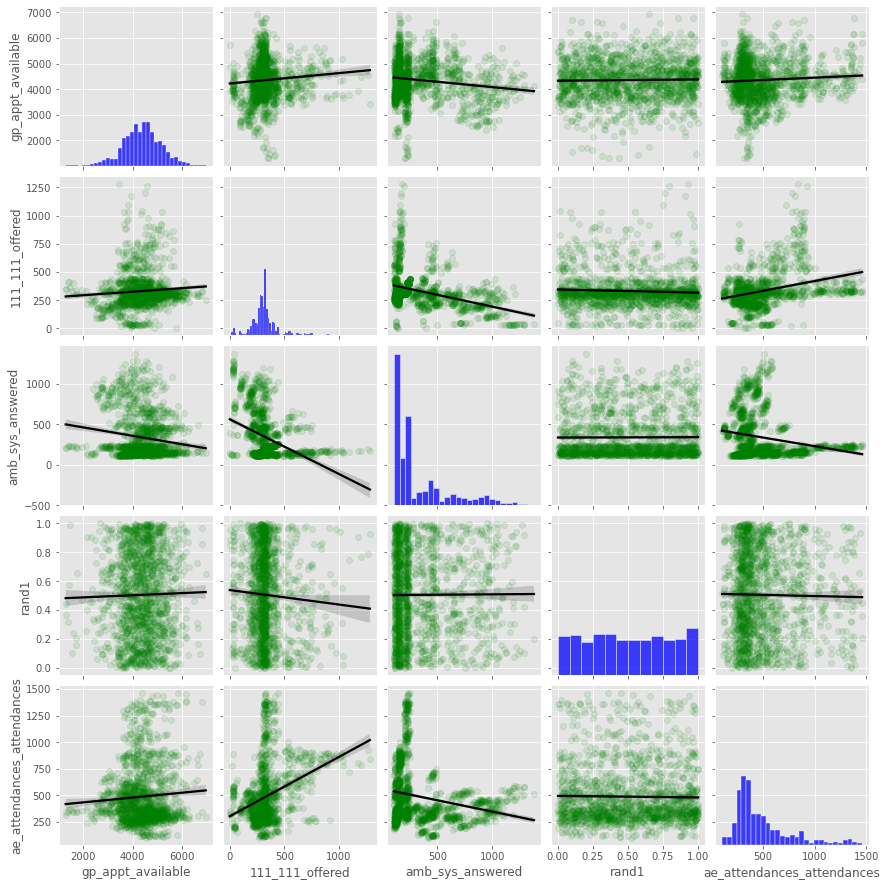

In [8]:
fig = sns.pairplot(dta[['gp_appt_available',
                        '111_111_offered', 'amb_sys_answered', 'rand1',
                        'ae_attendances_attendances']]\
                   .select_dtypes(include=np.number), 
                   kind="reg",
                   plot_kws={'line_kws':{'color':'black'}, 
                            'scatter_kws': 
                             {'color':'green','alpha': 0.1}},
                   diag_kws={'color':'blue'})

#plt.savefig('capacity_pair.png')

### Linear regression 

In [9]:
model = LinearRegression()

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.coef_)

#### Performance 

In [10]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [11]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.108675,0.101543
std,0.004542,0.020384
min,0.097622,0.044295
25%,0.106311,0.092900
50%,0.108783,0.101188
75%,0.111351,0.112308
max,0.118806,0.148487


#### Feature Importance 

In [12]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.009598,0.482105,-0.108052,-1.104265
std,0.003834,0.015173,0.009167,10.580058
min,0.001759,0.445220,-0.130048,-17.753052
25%,0.006948,0.471993,-0.114255,-9.148737
50%,0.009238,0.485835,-0.108573,0.305633
75%,0.012826,0.493194,-0.105030,5.107425
max,0.015941,0.505790,-0.090281,23.343977


### Random forest 

In [13]:
model = RandomForestRegressor(max_depth=5, n_estimators=5,
                              random_state=0)
#model = GradientBoostingRegressor(max_depth=5, n_estimators=5)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

#### Performance 

In [14]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [15]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.483899,0.405660
std,0.011387,0.038833
min,0.464652,0.317276
25%,0.475866,0.379986
50%,0.484438,0.410514
75%,0.490983,0.427913
max,0.504884,0.464062


#### Feature importance 

In [16]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.150022,0.181717,0.643637,0.024625
std,0.015431,0.033750,0.036853,0.012247
min,0.118339,0.139333,0.542964,0.008044
25%,0.136421,0.159817,0.628660,0.015440
50%,0.149805,0.174015,0.650672,0.021869
75%,0.163367,0.192388,0.670217,0.030682
max,0.177369,0.290965,0.689673,0.063046


### Gradient boosted tress

In [17]:
model = GradientBoostingRegressor(max_depth=5, n_estimators=5, 
                                  random_state=1)

features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered', 'rand1']

    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))
    
    feats.append(model.feature_importances_)

#### Performance 

In [18]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [19]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.311403,0.273163
std,0.005853,0.018242
min,0.301668,0.230263
25%,0.305942,0.262246
50%,0.312860,0.270050
75%,0.315097,0.284302
max,0.321119,0.306904


#### Feature Importance 

In [20]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered,rand1
count,25.000000,25.000000,25.000000,25.000000
mean,0.141035,0.180379,0.667589,0.010997
std,0.016080,0.016213,0.017408,0.006886
min,0.114726,0.145975,0.627435,0.000528
25%,0.130274,0.170380,0.654011,0.007174
50%,0.138989,0.178422,0.668998,0.009281
75%,0.154171,0.189696,0.679291,0.016403
max,0.188904,0.211450,0.693917,0.025793


### Summary 

**Linear Regression**

- Very poor performance, mean $R^2$ ~ 0.1

**Random Forest**

- Best performance with mean $R^2$ = 0.4 in test data
- Feature importance is stable: ambulance capacity is most important, followed by 111 then GP capacity. 
- The random feature has low importnace

**Gradient Boosted Trees**

- Doesn't perform as well as a Random Forest, mean $R^2$ = 0.27 in test data
- Feature importance is in agreement with the Random Forest


## Hyper parameter tuning 

The best model is the Random Forest. To ensure the model is not over fit to the training data we compare performance when the following parameters are varied:

- max_depth: the maximum size of any tree 
- n_estimators: the number of trees in the forest

### Maximum depth

In [21]:
d = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for depth in d:
    
    model = RandomForestRegressor(max_depth=depth, 
                                  n_estimators=4, random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

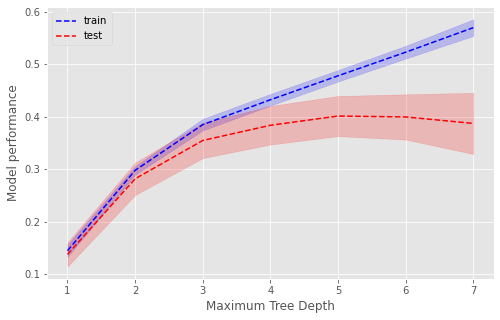

In [22]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Model performance')
plt.show()

A depth of 5 is optimal. After this, there is no improvement in performance on unseen data (test, red dashed line) and performance continues to increase in the training data (blue dashed line) suggesting overfitting.

### Number of trees

In [23]:
n = [1,2,3,4,5,6,7]

res_train,res_test = [],[]

for est in n:
    
    model = RandomForestRegressor(max_depth=5, n_estimators=est,
                                  random_state=0)

    y = dta['ae_attendances_attendances']

    X = dta[features]

    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)

    scores_train, scores_test = [],[]

    for train_index, test_index in cv.split(X, y):

        model.fit(X.iloc[train_index], y.iloc[train_index])

        scores_test.append(model.score(X.iloc[test_index],
                                       y.iloc[test_index]))
        scores_train.append(model.score(X.iloc[train_index],
                                        y.iloc[train_index]))
        
    res_train.append(scores_train)
    res_test.append(scores_test)

#### Plot 

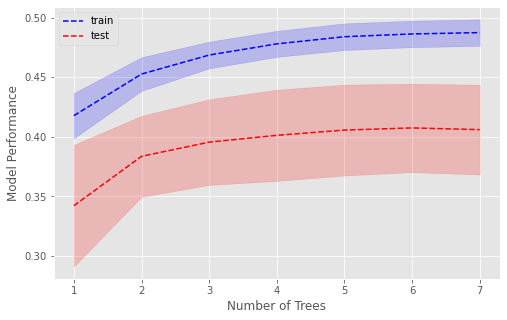

In [24]:
fig,ax = plt.subplots(figsize=(8,5))

plt.plot(d, np.mean(res_train, axis=1), 'b--', label='train')
plt.plot(d, np.mean(res_test, axis=1), 'r--', label='test')

plt.fill_between(d, y1=(np.mean(res_train, axis=1)-np.std(res_train, axis=1)),
                 y2=(np.mean(res_train, axis=1)+np.std(res_train, axis=1)),
                 color='b', alpha=0.2)

plt.fill_between(d, y1=(np.mean(res_test, axis=1)-np.std(res_test, axis=1)),
                 y2=(np.mean(res_test, axis=1)+np.std(res_test, axis=1)),
                 color='r', alpha=0.2)

plt.legend(loc='best')
plt.xlabel('Number of Trees')
plt.ylabel('Model Performance')

plt.show()

The optimal number of trees is 6, beyond which there is no improvement in the training or test set.

## Final Model for paper

Fit the Random forest with optimal parameters

In [25]:
model = RandomForestRegressor(max_depth=5, n_estimators=6,
                              random_state=0)


features = ['gp_appt_available',
            '111_111_offered', 'amb_sys_answered']
    
y = dta['ae_attendances_attendances']
X = dta[features]

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
    
scores_train, scores_test, feats = [],[],[]
    
for train_index, test_index in cv.split(X, y):
        
    model.fit(X.iloc[train_index], y.iloc[train_index])
        
    scores_test.append(model.score(X.iloc[test_index],
                                   y.iloc[test_index]))
    scores_train.append(model.score(X.iloc[train_index],
                                    y.iloc[train_index]))

    feats.append(model.feature_importances_)

### Performance 

In [26]:
results=pd.DataFrame()
results['train'] = scores_train
results['test'] = scores_test

In [27]:
results.describe()

,train,test
count,25.000000,25.000000
mean,0.484173,0.413448
std,0.011436,0.040615
min,0.461452,0.332147
25%,0.477639,0.381238
50%,0.482339,0.417617
75%,0.492477,0.444477
max,0.505810,0.475195


### Feature Importance

In [28]:
feat_imp = pd.DataFrame()

for i,f in enumerate(features):
    
    feat_imp[f] = np.array(feats)[:,i]

feat_imp.describe()

,gp_appt_available,111_111_offered,amb_sys_answered
count,25.000000,25.000000,25.000000
mean,0.158356,0.193212,0.648431
std,0.015942,0.033630,0.037786
min,0.127295,0.147441,0.546094
25%,0.146158,0.173721,0.632592
50%,0.161574,0.184419,0.655098
75%,0.166836,0.205277,0.674036
max,0.186875,0.286825,0.697182
